In [1]:

from langgraph.graph import StateGraph, END
from langchain_community.chat_models import ChatOllama

import pandas as pd
import random
from typing import TypedDict
from IPython.display import Image, display

# --- Define shared state schema ---
# This tells LangGraph what data each agent can read/write.
class AgentState(TypedDict, total=False):
    data_summary: str
    market_info: str
    forecast: str
    explanation: str

# --- Mock sales data ---
data = pd.DataFrame({
    "month": ["Jan", "Feb", "Mar", "Apr", "May", "Jun"],
    "sales": [120, 135, 160, 180, 175, 210]
})

# --- Initialize AI model ---
llm = ChatOllama(model="llama3", temperature=0.3)

# llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)

# --- Define agents ---
def data_agent(state: AgentState):
    df = data
    trend = "increasing" if df["sales"].iloc[-1] > df["sales"].iloc[0] else "decreasing"
    avg_growth = round((df["sales"].pct_change().mean()) * 100, 2)
    summary = f"Sales trend is {trend} with an average monthly growth of {avg_growth}%."
    return {"data_summary": summary}

def market_agent(state: AgentState):
    sentiment = random.choice(["positive", "neutral", "negative"])
    return {"market_info": f"Market sentiment is {sentiment}."}

def forecast_agent(state: AgentState):
    summary = state["data_summary"]
    market_info = state["market_info"]
    prompt = f"{summary} {market_info} Predict next month's sales and give reasoning."
    forecast_text = llm.invoke(prompt).content
    return {"forecast": forecast_text}

def explain_agent(state: AgentState):
    forecast = state["forecast"]
    prompt = f"Explain this forecast in simple business language:\n{forecast}"
    explanation = llm.invoke(prompt).content
    print("\n--- Forecast Explanation ---\n", explanation)
    return {"explanation": explanation}

# --- Build the LangGraph ---
graph = StateGraph(AgentState)

graph.add_node("data_agent", data_agent)
graph.add_node("market_agent", market_agent)
graph.add_node("forecast_agent", forecast_agent)
graph.add_node("explain_agent", explain_agent)

graph.add_edge("data_agent", "market_agent")
graph.add_edge("market_agent", "forecast_agent")
graph.add_edge("forecast_agent", "explain_agent")
graph.add_edge("explain_agent", END)
graph.set_entry_point("data_agent")

# --- Compile & run ---
app = graph.compile()
result = app.invoke({})
print("\n--- Final Agent Outputs ---\n")
print(result)



/var/folders/9k/fjwgdp8s2bd7ywp5b9yssgw00000gn/T/ipykernel_17203/1859652880.py:24: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the `langchain-ollama package and should be used instead. To use it run `pip install -U `langchain-ollama` and import as `from `langchain_ollama import ChatOllama``.
  llm = ChatOllama(model="llama3", temperature=0.3)



--- Forecast Explanation ---
 Here's a simplified explanation of the forecast:

**Current Sales**: Let's assume we're starting with $100,000 in sales.

**Growth Rate**: Our sales are increasing by 12.15% each month. This means that if we had $100,000 last month, we'll have about $112,150 this month (a 12.15% increase).

**Market Conditions**: The market is neutral, which means there aren't any significant changes that would affect our sales.

To predict next month's sales, we're using a simple formula:

Next Month's Sales = Current Sales × (1 + Growth Rate)

Plugging in the numbers:

$100,000 × (1 + 0.1215) ≈ $112,150

So, based on this calculation, we can expect our sales to grow by about 12.15% each month, which means next month's sales will be around $112,150.

Keep in mind that this is a simple prediction and doesn't take into account any external factors that could impact our sales, such as changes in the market or competition.

--- Final Agent Outputs ---

{'data_summary': 'Sale

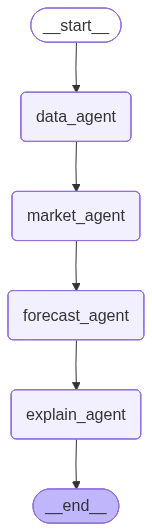

In [9]:
from IPython.display import Image, display

graph_bytes = app.get_graph(xray=True).draw_mermaid_png()
display(Image(graph_bytes))
